### Experimentos Métodos de Ensamble

#### Training diverse base estimators

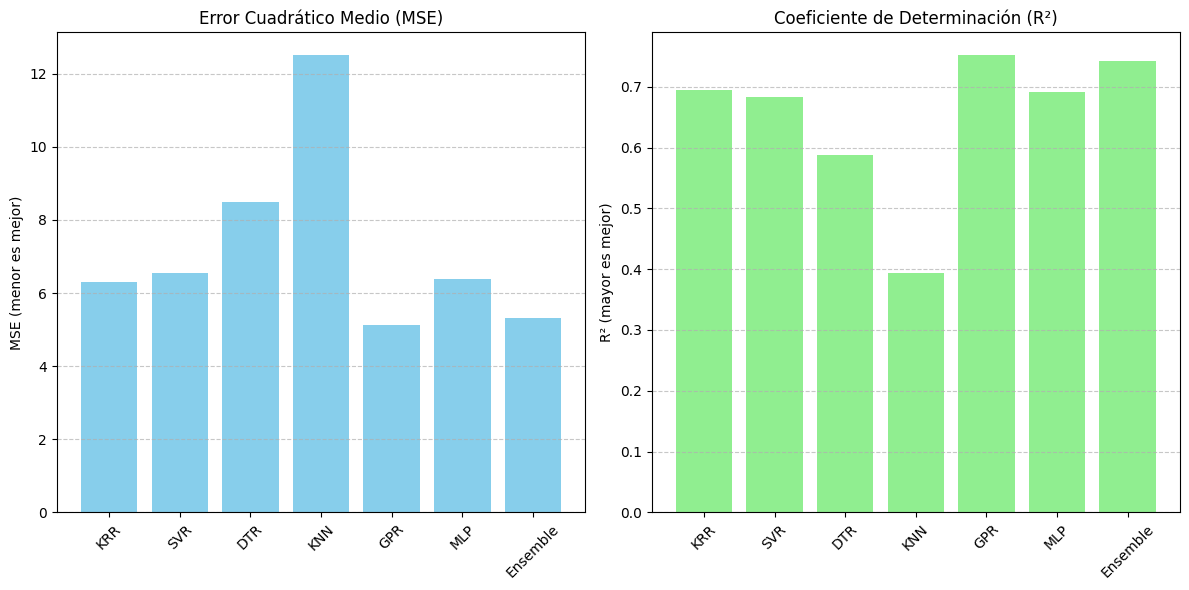

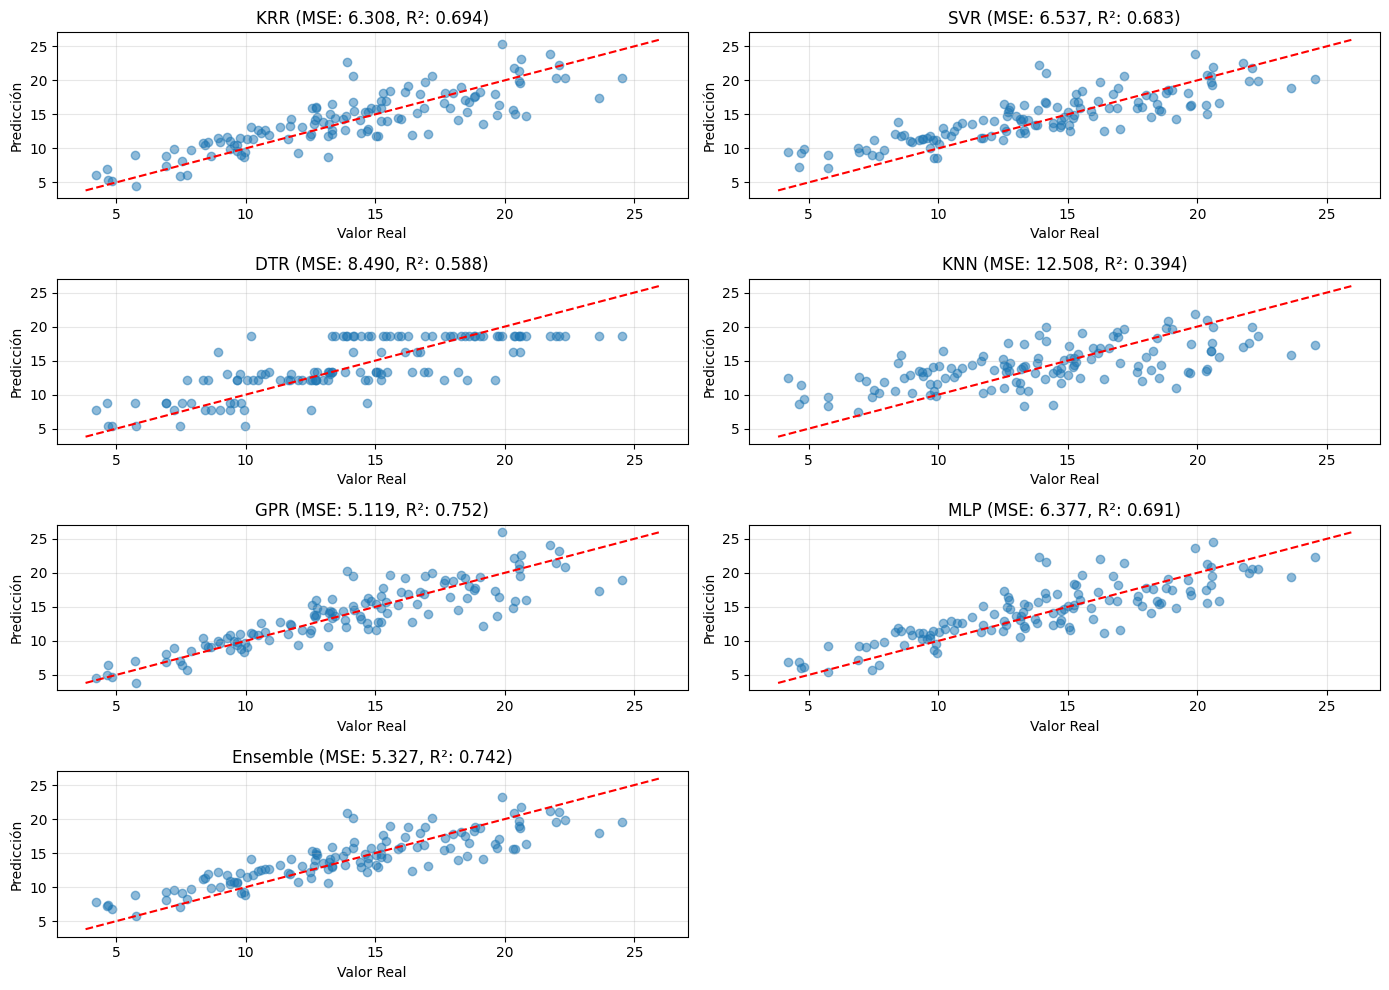

Resumen de rendimiento de los modelos:
------------------------------------------------------------
Modelo       | MSE        | R²        
------------------------------------------------------------
KRR          | 6.3085     | 0.6942    
SVR          | 6.5368     | 0.6832    
DTR          | 8.4897     | 0.5885    
KNN          | 12.5082    | 0.3937    
GPR          | 5.1193     | 0.7519    
MLP          | 6.3767     | 0.6909    
Ensemble     | 5.3272     | 0.7418    


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_friedman1
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

# Recrear los datos y modelos
X, y = make_friedman1(n_samples=500, n_features=15, noise=0.3, random_state=23)
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.25)

estimators = {
    'KRR': KernelRidge(kernel='rbf', gamma=0.25),
    'SVR': SVR(gamma=0.5),
    'DTR': DecisionTreeRegressor(max_depth=3),
    'KNN': KNeighborsRegressor(n_neighbors=4),
    'GPR': GaussianProcessRegressor(alpha=0.1),
    'MLP': MLPRegressor(alpha=25, max_iter=10000)
}

# Entrenar modelos y calcular métricas
mse_scores = {}
r2_scores = {}
predictions = {}

for name, estimator in estimators.items():
    # Entrenar modelo
    estimator.fit(Xtrn, ytrn)
    
    # Predecir
    y_pred = estimator.predict(Xtst)
    predictions[name] = y_pred
    
    # Calcular métricas
    mse = mean_squared_error(ytst, y_pred)
    r2 = r2_score(ytst, y_pred)
    
    mse_scores[name] = mse
    r2_scores[name] = r2

# Calcular predicción del ensamble
n_estimators, n_samples = len(estimators), Xtst.shape[0]
y_individual = np.zeros((n_samples, n_estimators))
for i, (model, estimator) in enumerate(estimators.items()):
    y_individual[:, i] = estimator.predict(Xtst)
y_final = np.mean(y_individual, axis=1)

# Calcular métricas para el ensamble
mse_ensemble = mean_squared_error(ytst, y_final)
r2_ensemble = r2_score(ytst, y_final)
mse_scores['Ensemble'] = mse_ensemble
r2_scores['Ensemble'] = r2_ensemble

# Gráfico de barras para MSE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(mse_scores.keys(), mse_scores.values(), color='skyblue')
plt.title('Error Cuadrático Medio (MSE)')
plt.xticks(rotation=45)
plt.ylabel('MSE (menor es mejor)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Gráfico de barras para R²
plt.subplot(1, 2, 2)
plt.bar(r2_scores.keys(), r2_scores.values(), color='lightgreen')
plt.title('Coeficiente de Determinación (R²)')
plt.xticks(rotation=45)
plt.ylabel('R² (mayor es mejor)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Gráfico de dispersión para comparar predicciones vs valores reales
plt.figure(figsize=(14, 10))
models_to_plot = list(estimators.keys()) + ['Ensemble']
rows = (len(models_to_plot) + 1) // 2
cols = 2

for i, name in enumerate(models_to_plot):
    plt.subplot(rows, cols, i+1)
    if name == 'Ensemble':
        plt.scatter(ytst, y_final, alpha=0.5)
    else:
        plt.scatter(ytst, predictions[name], alpha=0.5)
    
    # Línea de referencia (predicción perfecta)
    min_val = min(ytst.min(), min(predictions.values(), key=lambda x: x.min()).min())
    max_val = max(ytst.max(), max(predictions.values(), key=lambda x: x.max()).max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.title(f'{name} (MSE: {mse_scores[name]:.3f}, R²: {r2_scores[name]:.3f})')
    plt.xlabel('Valor Real')
    plt.ylabel('Predicción')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla de resultados
print("Resumen de rendimiento de los modelos:")
print("-" * 60)
print(f"{'Modelo':<12} | {'MSE':<10} | {'R²':<10}")
print("-" * 60)
for name in models_to_plot:
    print(f"{name:<12} | {mse_scores[name]:<10.4f} | {r2_scores[name]:<10.4f}")

#### Métodos de Ensamble con Hiperparámetros

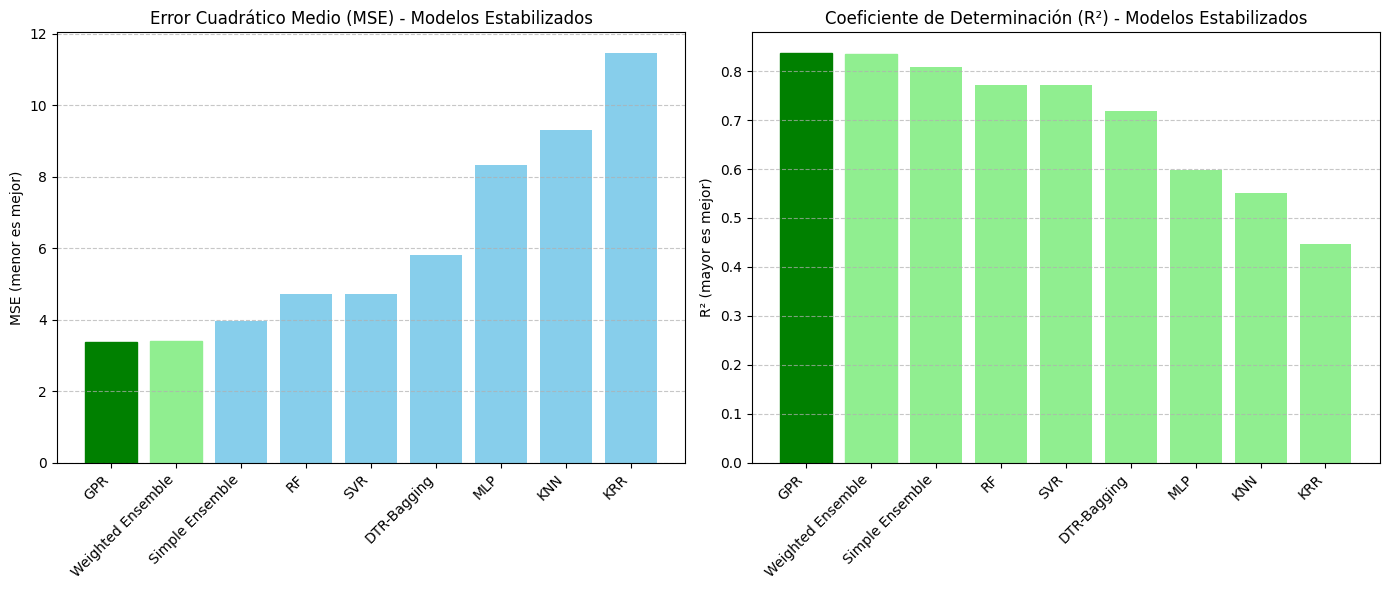

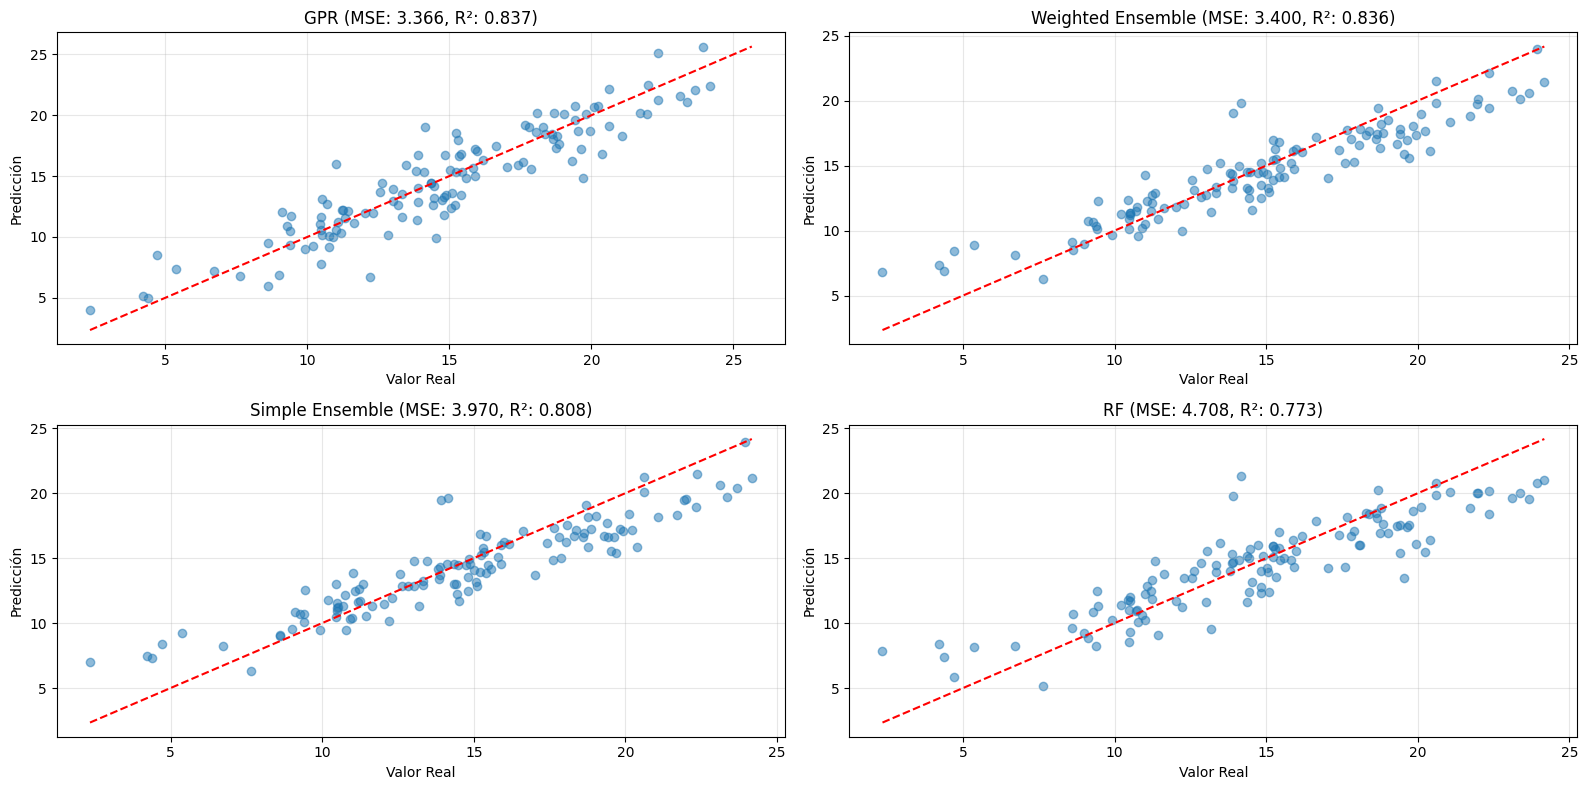

Resumen de rendimiento de los modelos estabilizados:
----------------------------------------------------------------------
Modelo               | MSE        | R²         | Peso en Ensamble    
----------------------------------------------------------------------
KRR                  | 11.4631    | 0.4461     | 0.0674              
SVR                  | 4.7167     | 0.7721     | 0.1644              
DTR-Bagging          | 5.8222     | 0.7187     | 0.1214              
KNN                  | 9.3064     | 0.5503     | 0.0880              
GPR                  | 3.3661     | 0.8374     | 0.2740              
MLP                  | 8.3223     | 0.5979     | 0.1105              
RF                   | 4.7084     | 0.7725     | 0.1744              
----------------------------------------------------------------------
Simple Ensemble      | 3.9701     | 0.8082     | N/A                 
Weighted Ensemble    | 3.4005     | 0.8357     | N/A                 

Análisis de estabilidad (bootstra

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor, BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Recrear los datos
X, y = make_friedman1(n_samples=500, n_features=15, noise=0.3, random_state=23)
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.25, random_state=42)

# Preprocesamiento - Estandarización
scaler = StandardScaler()
Xtrn_scaled = scaler.fit_transform(Xtrn)
Xtst_scaled = scaler.transform(Xtst)

# 1. Modelos estabilizados con mejores hiperparámetros
# Kernel Ridge con validación cruzada
krr = GridSearchCV(
    KernelRidge(kernel='rbf'),
    param_grid={"alpha": [0.1, 0.5, 1.0], "gamma": [0.1, 0.25, 0.5]},
    cv=5
).fit(Xtrn_scaled, ytrn)

# SVR con validación cruzada
svr = GridSearchCV(
    SVR(),
    param_grid={"C": [1, 10, 100], "gamma": [0.1, 0.5, 1.0]},
    cv=5
).fit(Xtrn_scaled, ytrn)

# Bagging para estabilizar DecisionTreeRegressor
dtr_bagging = BaggingRegressor(
    DecisionTreeRegressor(max_depth=3),
    n_estimators=50,
    random_state=42
).fit(Xtrn_scaled, ytrn)

# KNN con validación cruzada
knn = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={"n_neighbors": [3, 4, 5, 6]},
    cv=5
).fit(Xtrn_scaled, ytrn)

# GPR con kernel optimizado
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gpr = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.1,
    n_restarts_optimizer=10,
    random_state=42
).fit(Xtrn_scaled, ytrn)

# MLP con early stopping y validación
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    alpha=0.1,
    max_iter=10000,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
).fit(Xtrn_scaled, ytrn)

# Random Forest como modelo adicional estable
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42
).fit(Xtrn_scaled, ytrn)

# 2. Crear ensambles mejorados
# Ensamble con pesos optimizados
estimators = {
    'KRR': krr.best_estimator_,
    'SVR': svr.best_estimator_,
    'DTR-Bagging': dtr_bagging,
    'KNN': knn.best_estimator_,
    'GPR': gpr,
    'MLP': mlp,
    'RF': rf
}

# Calcular pesos basados en el rendimiento de validación cruzada
weights = {}
for name, model in estimators.items():
    scores = cross_val_score(model, Xtrn_scaled, ytrn, cv=5, scoring='neg_mean_squared_error')
    weights[name] = np.mean(-scores)  # Convertir a MSE positivo

# Normalizar pesos (menor MSE = mayor peso)
total = sum(1/w for w in weights.values())
for name in weights:
    weights[name] = (1/weights[name]) / total

# Crear VotingRegressor con pesos
named_estimators = [(name, model) for name, model in estimators.items()]
voting_weights = [weights[name] for name, _ in named_estimators]
voting_regressor = VotingRegressor(
    estimators=named_estimators,
    weights=voting_weights
).fit(Xtrn_scaled, ytrn)

# 3. Evaluar todos los modelos
models = {**estimators, 'Weighted Ensemble': voting_regressor}

# Calcular métricas
mse_scores = {}
r2_scores = {}
predictions = {}

for name, model in models.items():
    y_pred = model.predict(Xtst_scaled)
    predictions[name] = y_pred
    
    mse = mean_squared_error(ytst, y_pred)
    r2 = r2_score(ytst, y_pred)
    
    mse_scores[name] = mse
    r2_scores[name] = r2

# Calcular predicción del ensamble simple (promedio)
y_individual = np.zeros((Xtst.shape[0], len(estimators)))
for i, (model, estimator) in enumerate(estimators.items()):
    y_individual[:, i] = estimator.predict(Xtst_scaled)
y_simple_ensemble = np.mean(y_individual, axis=1)

# Calcular métricas para el ensamble simple
mse_simple_ensemble = mean_squared_error(ytst, y_simple_ensemble)
r2_simple_ensemble = r2_score(ytst, y_simple_ensemble)
mse_scores['Simple Ensemble'] = mse_simple_ensemble
r2_scores['Simple Ensemble'] = r2_simple_ensemble
predictions['Simple Ensemble'] = y_simple_ensemble

# 4. Visualizar resultados
# Gráfico de barras para MSE
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
models_sorted = sorted(mse_scores.items(), key=lambda x: x[1])
names = [x[0] for x in models_sorted]
values = [x[1] for x in models_sorted]
bars = plt.bar(names, values, color='skyblue')
plt.title('Error Cuadrático Medio (MSE) - Modelos Estabilizados')
plt.xticks(rotation=45, ha='right')
plt.ylabel('MSE (menor es mejor)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Resaltar los mejores modelos
bars[0].set_color('green')
bars[1].set_color('lightgreen')

# Gráfico de barras para R²
plt.subplot(1, 2, 2)
models_sorted = sorted(r2_scores.items(), key=lambda x: x[1], reverse=True)
names = [x[0] for x in models_sorted]
values = [x[1] for x in models_sorted]
bars = plt.bar(names, values, color='lightgreen')
plt.title('Coeficiente de Determinación (R²) - Modelos Estabilizados')
plt.xticks(rotation=45, ha='right')
plt.ylabel('R² (mayor es mejor)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Resaltar los mejores modelos
bars[0].set_color('green')
bars[1].set_color('lightgreen')

plt.tight_layout()
plt.show()

# Gráfico de dispersión para comparar los mejores modelos
plt.figure(figsize=(16, 8))
best_models = ['GPR', 'Weighted Ensemble', 'Simple Ensemble', 'RF']
for i, name in enumerate(best_models):
    plt.subplot(2, 2, i+1)
    plt.scatter(ytst, predictions[name], alpha=0.5)
    
    # Línea de referencia (predicción perfecta)
    min_val = min(ytst.min(), predictions[name].min())
    max_val = max(ytst.max(), predictions[name].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.title(f'{name} (MSE: {mse_scores[name]:.3f}, R²: {r2_scores[name]:.3f})')
    plt.xlabel('Valor Real')
    plt.ylabel('Predicción')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabla de resultados
print("Resumen de rendimiento de los modelos estabilizados:")
print("-" * 70)
print(f"{'Modelo':<20} | {'MSE':<10} | {'R²':<10} | {'Peso en Ensamble':<20}")
print("-" * 70)
for name in estimators.keys():
    print(f"{name:<20} | {mse_scores[name]:<10.4f} | {r2_scores[name]:<10.4f} | {weights[name]:<20.4f}")
print("-" * 70)
print(f"{'Simple Ensemble':<20} | {mse_scores['Simple Ensemble']:<10.4f} | {r2_scores['Simple Ensemble']:<10.4f} | {'N/A':<20}")
print(f"{'Weighted Ensemble':<20} | {mse_scores['Weighted Ensemble']:<10.4f} | {r2_scores['Weighted Ensemble']:<10.4f} | {'N/A':<20}")

# Análisis de estabilidad mediante bootstrapping
from sklearn.utils import resample

n_bootstraps = 50
bootstrap_scores = {name: [] for name in models.keys()}

print("\nAnálisis de estabilidad (bootstrapping con", n_bootstraps, "iteraciones):")
for i in range(n_bootstraps):
    # Crear muestra bootstrap
    X_boot, y_boot = resample(Xtst_scaled, ytst, random_state=i)
    
    # Evaluar cada modelo
    for name, model in models.items():
        y_pred = model.predict(X_boot)
        mse = mean_squared_error(y_boot, y_pred)
        bootstrap_scores[name].append(mse)

# Calcular estadísticas de estabilidad
stability_stats = {}
for name, scores in bootstrap_scores.items():
    mean_mse = np.mean(scores)
    std_mse = np.std(scores)
    stability_stats[name] = (mean_mse, std_mse)

# Mostrar estadísticas de estabilidad
print("-" * 70)
print(f"{'Modelo':<20} | {'MSE Promedio':<15} | {'Desviación Estándar':<20} | {'Coef. Variación (%)':<20}")
print("-" * 70)
for name, (mean_mse, std_mse) in sorted(stability_stats.items(), key=lambda x: x[1][0]):
    cv = (std_mse / mean_mse) * 100  # Coeficiente de variación
    print(f"{name:<20} | {mean_mse:<15.4f} | {std_mse:<20.4f} | {cv:<20.2f}")